In [1]:
import sys
sys.path.append('..')

In [2]:
from inxai import *
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

# Create synthetic classification dataset

### Make classification

In [3]:
n_features = 4
X, y = make_classification(n_samples=1000, n_informative=2, n_features=n_features, n_redundant=2)
X = preprocessing.normalize(X)
X=pd.DataFrame(data=X)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## XGBoost

In [5]:
X_train.columns = ['0','1','2','3']
X_test.columns = ['0','1','2','3']
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print(accuracy_score(y_test, xgb_preds))

print(classification_report(y_test, xgb_preds))

0.9212121212121213
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       160
           1       0.92      0.92      0.92       170

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



### Permutation importance

In [6]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
perm_importances = perm.feature_importances_
feature_names = [str(i) for i in range(n_features)]
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.3600 ± 0.0551,3
0.0467 ± 0.0194,2
-0.0079 ± 0.0178,1
-0.0200 ± 0.0165,0


In [7]:
gm = GlobalFeatureMetric()

In [8]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test.columns)])


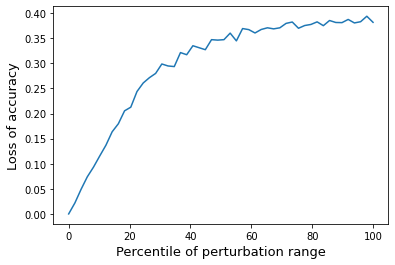

In [9]:
acc_loss = gm.gradual_perturbation(model=xgb_model, X=X_test, y=y_test, column_transformer=ct, importances_orig=perm_importances, resolution=50,  count_per_step=10)

In [10]:
from sklearn.metrics import auc
1-auc(np.linspace(0, 1, 50), acc_loss)

0.7004700061842919

### Check stability

In [11]:
shape_lips = gm.stability(X_test,generate_per_instance_importances(models=xgb_model, X=X_test, y=y_test, framework='tree_shap') )

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [12]:
lime_lips = gm.stability(X_test,generate_per_instance_importances(models=xgb_model, X=X_test, y=y_test, framework='lime') )

<AxesSubplot:xlabel='variable', ylabel='value'>

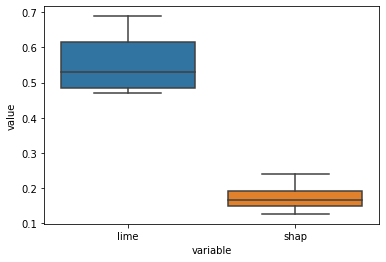

In [13]:
lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

### Check consistency

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
res = generate_per_instance_importances(models=[xgb_model, lr], X=X_test, y=y_test, framework='lime') 

In [16]:
lime_cons = gm.consistency(res)

<AxesSubplot:xlabel='variable', ylabel='value'>

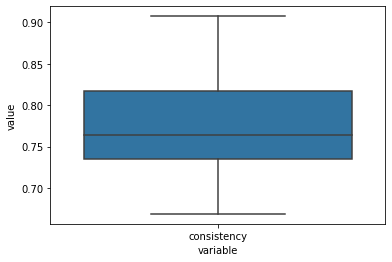

In [17]:
cons_df = pd.DataFrame({'consistency':lime_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df))

In [18]:
lip_df

,lime,shap
0,0.510690,0.156294
1,0.490854,0.166071
2,0.550260,0.167344
3,0.480845,0.139212
4,0.503610,0.155901
...,...,...
325,0.688539,0.206818
326,0.617477,0.197194
327,0.654721,0.179692
328,0.469007,0.140549


# Make circles

In [19]:
X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.08)#factor=0.5

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['0','1']
X_test.columns = ['0','1']

<AxesSubplot:xlabel='0', ylabel='1'>

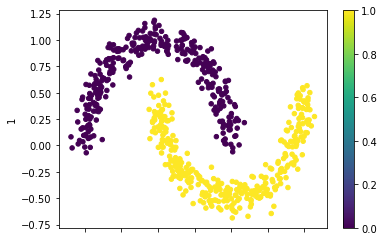

In [21]:
X_train.plot(kind='scatter',x='0', y='1',style='.', c=y_train, colormap='viridis')

In [22]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='poly',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9242424242424242
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       167
           1       0.87      0.99      0.93       163

    accuracy                           0.92       330
   macro avg       0.93      0.93      0.92       330
weighted avg       0.93      0.92      0.92       330



In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [24]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.8636363636363636
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       167
           1       0.86      0.87      0.86       163

    accuracy                           0.86       330
   macro avg       0.86      0.86      0.86       330
weighted avg       0.86      0.86      0.86       330



<AxesSubplot:xlabel='0', ylabel='1'>

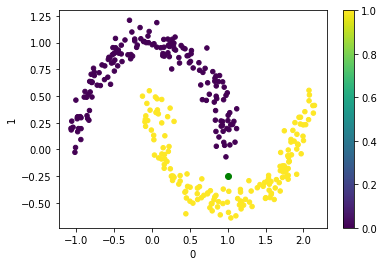

In [25]:
fig, ax = plt.subplots()
point = [1.0,-0.25]
ax.plot(point[0], point[1], 'og')
X_test.plot(kind='scatter',x='0', y='1', c=y_test, colormap='viridis', ax=ax)

In [26]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['0','1']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

### Stability

In [27]:
gm = GlobalFeatureMetric()

In [28]:
shap_res=generate_per_instance_importances(models=svc, X=X_test_appended, y=y_test_appended, framework='kernel_shap')
lime_res = generate_per_instance_importances(models=svc, X=X_test_appended, y=y_test_appended, framework='lime')

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/331 [00:00<?, ?it/s]

<AxesSubplot:xlabel='variable', ylabel='value'>

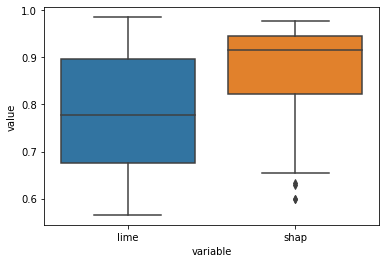

In [29]:
shape_lips = gm.stability(X_test_appended,shap_res ,epsilon=0.3)

lime_lips = gm.stability(X_test_appended,lime_res,epsilon=0.3 )

lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

### Consistency per model

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/331 [00:00<?, ?it/s]

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/331 [00:00<?, ?it/s]

<AxesSubplot:xlabel='variable', ylabel='value'>

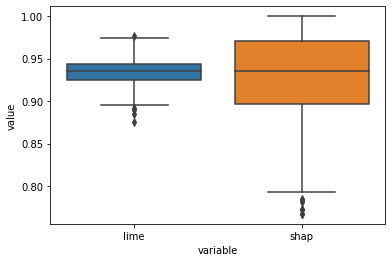

In [30]:
res_lime_con = generate_per_instance_importances(models=[svc, lr], X=X_test_appended, y=y_test_appended, framework='lime') 
res_shap_con = generate_per_instance_importances(models=[svc, lr], X=X_test_appended, y=y_test_appended, framework='kernel_shap') 
lime_cons = gm.consistency(res_lime_con)
shap_cons = gm.consistency(res_shap_con)
cons_df = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df))

## Area under the ACCLOSS

In [31]:
import shap
import lime

In [32]:
explainer_shap = shap.KernelExplainer(svc.predict_proba, X_train)

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [33]:
explainer_lime =lime.lime_tabular.LimeTabularExplainer(X_train,feature_names=list(X_train.columns), 
                                                       class_names=['0','1'], discretize_continuous=False)

In [34]:
shap_res_instance = explainer_shap.shap_values(X_test_appended)

  0%|          | 0/331 [00:00<?, ?it/s]

In [35]:
explainer_lime.explain_instance(X_test.iloc[0],svc.predict_proba).as_list()

[('1', -0.44031558998489234), ('0', 0.12889359748650872)]

In [36]:
def expl(row):
    e = explainer_lime.explain_instance(row,svc.predict_proba).as_list()
    return [e[0][1],e[1][1]]

In [37]:
shap_res_global = pd.DataFrame(shap_res_instance[0]).apply(abs).mean()

In [38]:
lime_res_global = X_test.apply(lambda x: expl(x), axis=1, result_type='expand').apply(abs).mean()

In [39]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test_appended.columns)])

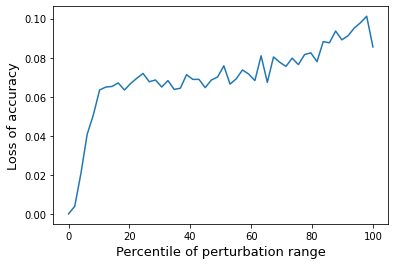

In [40]:
acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=shap_res_global, resolution=50,  count_per_step=10)

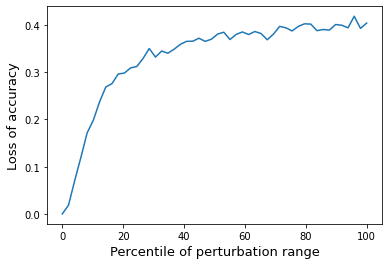

In [41]:
acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=lime_res_global, resolution=50,  count_per_step=10)